In [1]:
#%pylab inline
%matplotlib inline
from array import array
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
from root_numpy.tmva import add_classification_events, evaluate_reader
from ROOT import TMVA, TFile, TCut
# Classify the test dataset with the classifier
reader = TMVA.Reader()
from root_numpy import root2array, rec2array
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.ranking import _binary_clf_curve

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import copy
import xgboost as xgb

tree_prefix = '/home/llr/cms/pigard/ZZjj_generator_study/'

branch_names = ['m_jj', 
                'dEta_tj', 
                'm_4l',
                'Z1_zepp', 
                'Z2_zepp', 
                'dPhi_Z1_Z2', 
                'tj1_eta_x_tj2_eta', 
                'costhetastar', 
                'phi', 
                'costheta1', 
                'costheta2', 
                'phi1',
                'vbf_costhetastar',
                'vbf_costheta1',
                'vbf_costheta2',
                'vbf_phi',
                'vbf_phi1',
                'qv1',
                'qv2',
                'jet_Dphi',
                'tj1_qg',
                'tj2_qg',
                'ntj_n',
                'ntj_scalar_sum_pt',
                'ntj_central_n',
                'ntj_central_scalar_sum_pt',
                'max_4l_eta',
                'tj_min_eta',
                'tj_max_eta',
                'R_vector',
                'R_scalar',
                
                'rel_pt_hard',
                'tj_delta_rel',
                'tj_sum_abs_eta',
                'tj2_eta',
                'tj1_eta',
                'tj2_pt', #is actually Z2
                'tj1_pt',#is actually Z1
                'm_jj_over_dEta_tj',               
                ]
signal = root2array(tree_prefix + 'zzjj_ewk_tight_v6_ZZ4lAnalysis_MVA_tree.root',
                    "test",
                    branch_names, stop = 100000)


backgr = root2array(tree_prefix + 'zzjj_qcd_tight_v6_ZZ4lAnalysis_MVA_tree.root',
                    "test",
                    branch_names, stop = 100000)

Welcome to ROOTaaS 6.06/00


In [2]:
from sklearn.cross_validation import train_test_split

def varset_training(estimator, sig, back, variable_names = []) :
    out_list = []
    
    for var in variable_names :
    
        print var
        
        
        red_back = rec2array(back[var])
        red_sig = rec2array(sig[var])
        
        X = np.concatenate((red_sig, red_back))
        y = np.concatenate((np.ones(sig.shape[0]) ,
                            np.zeros(back.shape[0])))
        
    
        X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                              test_size=0.33, random_state=42)
        X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev,
                                                  test_size=0.33, random_state=492)
    
        est = copy.deepcopy(estimator)
        est.fit(X_train, y_train)
        
        est_decisions = est.predict_proba(X_test)[:, 1]
        est_fpr, est_tpr, thresholds = roc_curve(y_test, est_decisions)
        
        out_list.append((var, est, est_fpr, est_tpr))
    return out_list

In [3]:
#gbdt = GradientBoostingClassifier(n_estimators=1400, learning_rate =.02, max_depth=8, random_state=0, min_samples_leaf = 800)
#gbdt = GradientBoostingClassifier(n_estimators=800, learning_rate =.1, max_depth=4, random_state=0)
gbm = xgb.XGBClassifier(max_depth=8, n_estimators=2000, learning_rate=0.01, nthread=10)

classic_vbf = ['m_jj', 
                'dEta_tj', 
                'm_4l',
                'Z1_zepp', 
                'Z2_zepp', 
                'dPhi_Z1_Z2', 
                'tj1_eta_x_tj2_eta']
prod_angles = [
                'vbf_costhetastar',
                'vbf_costheta1',
                'vbf_costheta2',
                'vbf_phi',
                'vbf_phi1',
                'qv1',
                'qv2',]

decay_angles = ['costhetastar', 
                'phi', 
                'costheta1', 
                'costheta2', 
                'phi1',
    
]

hadronic_activity = [  'ntj_n',
                'ntj_scalar_sum_pt',
                'ntj_central_n',
                'ntj_central_scalar_sum_pt']

new_var = [     'max_4l_eta',
                'tj_min_eta',
                'tj_max_eta',
                'rel_pt_hard',
                'tj_delta_rel',
                'tj_sum_abs_eta',
                'tj2_eta',
                'tj1_eta',
                'tj2_pt', #is actually Z2
                'tj1_pt',#is actually Z1
                'm_jj_over_dEta_tj'
          ]


qg = ['tj1_qg', 'tj2_qg']

varsets = [classic_vbf + prod_angles,
           classic_vbf + decay_angles,
           classic_vbf + prod_angles + decay_angles,
           classic_vbf + new_var,
           classic_vbf + prod_angles + decay_angles + new_var,
           classic_vbf + prod_angles + decay_angles + new_var + hadronic_activity,
           classic_vbf + prod_angles + decay_angles + new_var + hadronic_activity + qg,           
        
          ]

#'vbf+pa', 'vbf+da', 'vbf+pda', 'vbf+nv', 'vbf+pda+nv', 'vbf+pda+nv+ha', 'vbf+pda+nv+ha+qg'


In [8]:
result = varset_training(gbm, signal, backgr, varsets)

['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'dPhi_Z1_Z2', 'tj1_eta_x_tj2_eta', 'vbf_costhetastar', 'vbf_costheta1', 'vbf_costheta2', 'vbf_phi', 'vbf_phi1', 'qv1', 'qv2']
['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'dPhi_Z1_Z2', 'tj1_eta_x_tj2_eta', 'costhetastar', 'phi', 'costheta1', 'costheta2', 'phi1']
['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'dPhi_Z1_Z2', 'tj1_eta_x_tj2_eta', 'vbf_costhetastar', 'vbf_costheta1', 'vbf_costheta2', 'vbf_phi', 'vbf_phi1', 'qv1', 'qv2', 'costhetastar', 'phi', 'costheta1', 'costheta2', 'phi1']
['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'dPhi_Z1_Z2', 'tj1_eta_x_tj2_eta', 'max_4l_eta', 'tj_min_eta', 'tj_max_eta', 'rel_pt_hard', 'tj_delta_rel', 'tj_sum_abs_eta', 'tj2_eta', 'tj1_eta', 'tj2_pt', 'tj1_pt', 'm_jj_over_dEta_tj']
['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'dPhi_Z1_Z2', 'tj1_eta_x_tj2_eta', 'vbf_costhetastar', 'vbf_costheta1', 'vbf_costheta2', 'vbf_phi', 'vbf_phi1', 'qv1', 'qv2', 'costhetastar', 'phi', 'costheta1'

In [4]:
from sklearn.metrics import auc


def plot_varset_training(result, labels = []) :
    for i in range(len(result)) :
        entry = result[i]
        fpr = entry[2]
        tpr = entry[3]
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label=labels[i] + '(%0.4f)'%(roc_auc))
#plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.])
    plt.ylim([0., 1.05])
    plt.xlabel('background efficiency')
    plt.ylabel('signal efficiency')
    plt.title('ROC')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [5]:
from IPython.core.pylabtools import figsize

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
figsize(12, 8)
#plot_varset_training(result, ('vbf+pa', 'vbf+da', 'vbf+pda', 'vbf+nv', 'vbf+pda+nv', 'vbf+pd+nv+ha', 'vbf+pd+nv+ha+qg'))

In [6]:
varset2 = [
    classic_vbf + new_var + hadronic_activity + qg,
    classic_vbf + new_var + hadronic_activity,
    classic_vbf + new_var + qg    
]
#result2 = varset_training(gbm, signal, backgr, varset2)

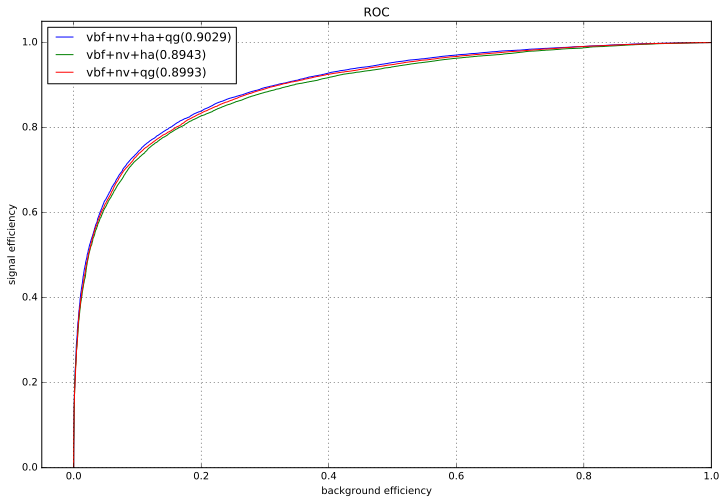

In [12]:
plot_varset_training(result2, ('vbf+nv+ha+qg', 'vbf+nv+ha', 'vbf+nv+qg', 'vbf+nv', 'vbf+pda+nv', 'vbf+pd+nv+ha', 'vbf+pd+nv+ha+qg'))

In [7]:
def n_minus_one_training(estimator, sig, back, variable_names) :
    #orig_list = copy.copy(variable_names)
    orig_list = variable_names
    out_list = []
    
    variable_names.append('all')
    for var in variable_names :
        #tmp_list = copy.copy(orig_list)
        reduced_list = [ v for v in orig_list if v is not var and v is not 'all'] #.remove(var)
        print 'orig list: ', orig_list 
        print 'removing: ', var
        print reduced_list
        
        red_back = rec2array(back[reduced_list])
        red_sig = rec2array(sig[reduced_list])
        
        X = np.concatenate((red_sig, red_back))
        y = np.concatenate((np.ones(sig.shape[0]) ,
                            np.zeros(back.shape[0])))
        
    
        X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                              test_size=0.33, random_state=42)
        X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev,
                                                  test_size=0.33, random_state=492)
    
        est = copy.deepcopy(estimator)
        est.fit(X_train, y_train)
        
        est_decisions = est.predict_proba(X_test)[:, 1]
        est_fpr, est_tpr, thresholds = roc_curve(y_test, est_decisions)
        
        out_list.append((var, reduced_list, est, est_fpr, est_tpr))
    return out_list

In [15]:
result_N_minus_1 = n_minus_one_training(gbm, signal, backgr, classic_vbf + new_var + hadronic_activity + qg)

orig list:  ['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'dPhi_Z1_Z2', 'tj1_eta_x_tj2_eta', 'max_4l_eta', 'tj_min_eta', 'tj_max_eta', 'rel_pt_hard', 'tj_delta_rel', 'tj_sum_abs_eta', 'tj2_eta', 'tj1_eta', 'tj2_pt', 'tj1_pt', 'm_jj_over_dEta_tj', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg', 'all']
removing:  m_jj
['dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'dPhi_Z1_Z2', 'tj1_eta_x_tj2_eta', 'max_4l_eta', 'tj_min_eta', 'tj_max_eta', 'rel_pt_hard', 'tj_delta_rel', 'tj_sum_abs_eta', 'tj2_eta', 'tj1_eta', 'tj2_pt', 'tj1_pt', 'm_jj_over_dEta_tj', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg']
orig list:  ['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'dPhi_Z1_Z2', 'tj1_eta_x_tj2_eta', 'max_4l_eta', 'tj_min_eta', 'tj_max_eta', 'rel_pt_hard', 'tj_delta_rel', 'tj_sum_abs_eta', 'tj2_eta', 'tj1_eta', 'tj2_pt', 'tj1_pt', 'm_jj_over_dEta_tj', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_

In [14]:
def plot_n_minus_one(result) :
    for entry in result :
        if entry[0] is 'all' :
            ref_auc = auc(entry[3], entry[4])
    for entry in result :
        fpr = entry[3]
        tpr = entry[4]
        plt.plot(fpr, tpr, lw=1, label='minus ' + entry[0] + str(auc(fpr, tpr) / ref_auc - 1))
#plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, .45])
    plt.ylim([0.45, 1.05])
    plt.xlabel('background efficiency')
    plt.ylabel('signal efficiency')
    plt.title('N-1 training ROC')
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    
def get_ranking(result) :
    ranking = {}
    for entry in result :
        if entry[0] is 'all' :
            ref_auc = auc(entry[3], entry[4])
            print 'reference AUC: ',ref_auc 
    for entry in result :
        fpr = entry[3]
        tpr = entry[4]
        curr_auc = auc(fpr, tpr)
        
        ranking[entry[0]] = curr_auc - ref_auc
        
    import operator
    sorted_ranking = sorted(ranking.items(), key=operator.itemgetter(1))
    print sorted_ranking
    return sorted_ranking
            

In [20]:
get_ranking(result_N_minus_1)
#plot_n_minus_one(result_N_minus_1)

[('tj1_qg', -0.004784347676113021), ('Z1_zepp', -0.0039294884366483096), ('Z2_zepp', -0.0037948460889453139), ('rel_pt_hard', -0.0032802042511730356), ('tj2_qg', -0.0030951538704694359), ('tj_delta_rel', -0.0022088964937381217), ('ntj_central_scalar_sum_pt', -0.0013687176068757356), ('m_4l', -0.00095138565181751567), ('ntj_scalar_sum_pt', -0.00082239942826212165), ('ntj_n', -0.00077920320925162212), ('m_jj', -0.00066696238615648884), ('tj1_pt', -0.00061920649238111913), ('ntj_central_n', -0.00038025826030596566), ('tj2_pt', -0.00036590111479761767), ('tj1_eta', -0.0003021566979342083), ('dEta_tj', -0.00027160851350060966), ('tj_max_eta', -0.00026318876413655712), ('m_jj_over_dEta_tj', -0.0001335080544516698), ('tj2_eta', -4.3113371622327534e-05), ('dPhi_Z1_Z2', -2.9582654380133633e-05), ('tj_min_eta', -1.2017985304590972e-05), ('all', 0.0), ('tj_sum_abs_eta', 4.9387271355172402e-05), ('max_4l_eta', 9.0757779406591688e-05), ('tj1_eta_x_tj2_eta', 0.00010006532547235381)]


[('tj1_qg', -0.004784347676113021),
 ('Z1_zepp', -0.0039294884366483096),
 ('Z2_zepp', -0.0037948460889453139),
 ('rel_pt_hard', -0.0032802042511730356),
 ('tj2_qg', -0.0030951538704694359),
 ('tj_delta_rel', -0.0022088964937381217),
 ('ntj_central_scalar_sum_pt', -0.0013687176068757356),
 ('m_4l', -0.00095138565181751567),
 ('ntj_scalar_sum_pt', -0.00082239942826212165),
 ('ntj_n', -0.00077920320925162212),
 ('m_jj', -0.00066696238615648884),
 ('tj1_pt', -0.00061920649238111913),
 ('ntj_central_n', -0.00038025826030596566),
 ('tj2_pt', -0.00036590111479761767),
 ('tj1_eta', -0.0003021566979342083),
 ('dEta_tj', -0.00027160851350060966),
 ('tj_max_eta', -0.00026318876413655712),
 ('m_jj_over_dEta_tj', -0.0001335080544516698),
 ('tj2_eta', -4.3113371622327534e-05),
 ('dPhi_Z1_Z2', -2.9582654380133633e-05),
 ('tj_min_eta', -1.2017985304590972e-05),
 ('all', 0.0),
 ('tj_sum_abs_eta', 4.9387271355172402e-05),
 ('max_4l_eta', 9.0757779406591688e-05),
 ('tj1_eta_x_tj2_eta', 0.000100065325472

In [9]:
prune_1 = classic_vbf + new_var + hadronic_activity + qg
prine_1_remove = ['tj1_eta_x_tj2_eta', 'max_4l_eta', 'tj_sum_abs_eta', 'tj_min_eta', 'dPhi_Z1_Z2', 'tj2_eta']
prune_1 = [var for var in prune_1 if var not in prine_1_remove]
print prune_1
#prune_1_result = varset_training(gbm, signal, backgr, [classic_vbf + new_var + hadronic_activity + qg, prune_1]) 

['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'tj_max_eta', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj2_pt', 'tj1_pt', 'm_jj_over_dEta_tj', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg']


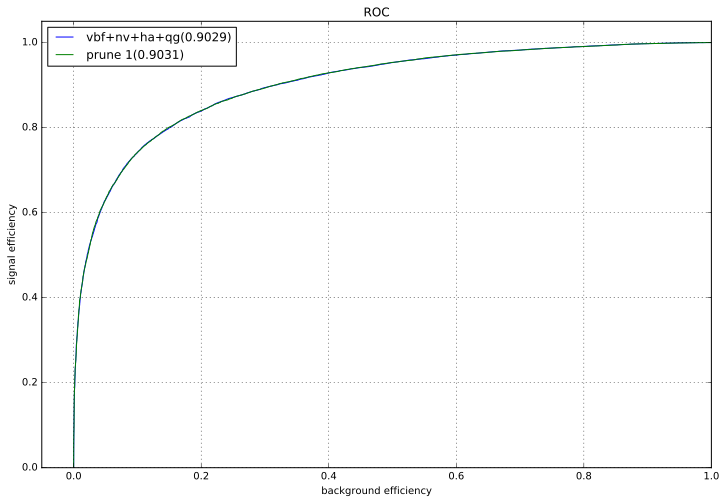

In [26]:
plot_varset_training(prune_1_result, [ 'vbf+nv+ha+qg','prune 1'])

['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj2_pt', 'tj1_pt', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg']
['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'dPhi_Z1_Z2', 'tj1_eta_x_tj2_eta', 'max_4l_eta', 'tj_min_eta', 'tj_max_eta', 'rel_pt_hard', 'tj_delta_rel', 'tj_sum_abs_eta', 'tj2_eta', 'tj1_eta', 'tj2_pt', 'tj1_pt', 'm_jj_over_dEta_tj', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg']
['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj2_pt', 'tj1_pt', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg']


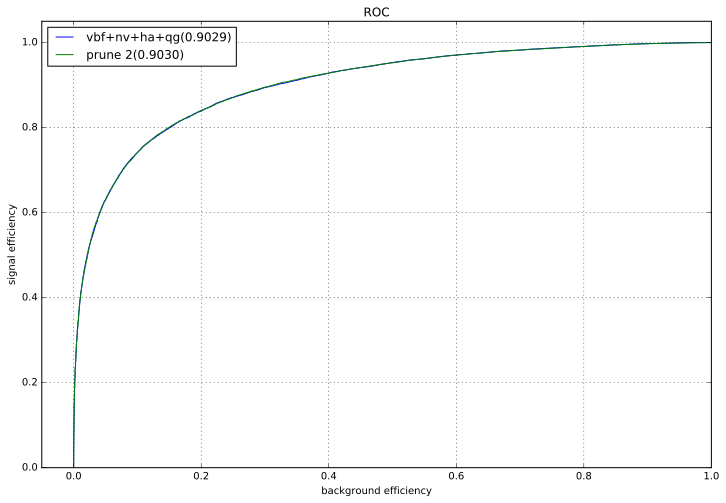

In [16]:
prune_2 = prune_1
prune_2_remove = ['m_jj_over_dEta_tj', 'tj_max_eta']
prune_2 = [var for var in prune_1 if var not in prune_2_remove]
print prune_2
prune_2_result = varset_training(gbm, signal, backgr, [classic_vbf + new_var + hadronic_activity + qg, prune_2])
plot_varset_training(prune_2_result, [ 'vbf+nv+ha+qg','prune 2'])

In [22]:
len(prune_2)

16

In [11]:
result_N_minus_1_prune_2 = n_minus_one_training(gbm, signal, backgr, prune_2)

orig list:  ['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj2_pt', 'tj1_pt', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg', 'all']
removing:  m_jj
['dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj2_pt', 'tj1_pt', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg']
orig list:  ['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj2_pt', 'tj1_pt', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg', 'all']
removing:  dEta_tj
['m_jj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj2_pt', 'tj1_pt', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg']
orig list:  ['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj2_pt', 

In [15]:
get_ranking(result_N_minus_1_prune_2)
#plot_n_minus_one(result_N_minus_1_prune_1)

reference AUC:  0.903037956647
[('tj1_eta', -0.0055681780654088797), ('Z1_zepp', -0.0051175752129909435), ('Z2_zepp', -0.0049234975354107702), ('tj1_qg', -0.0044133560495824842), ('rel_pt_hard', -0.0030502004685863948), ('tj2_qg', -0.002855885499721933), ('tj_delta_rel', -0.0024857090505774337), ('ntj_central_scalar_sum_pt', -0.0016401164448881511), ('tj1_pt', -0.0013709125512556541), ('m_4l', -0.00092779767078798869), ('ntj_scalar_sum_pt', -0.00090767598356256141), ('dEta_tj', -0.00079751350481982453), ('ntj_n', -0.00075872660790698987), ('ntj_central_n', -0.00036824334342300258), ('tj2_pt', -0.00021763497439186708), ('all', 0.0), ('m_jj', 0.00018277565735747014)]


[('tj1_eta', -0.0055681780654088797),
 ('Z1_zepp', -0.0051175752129909435),
 ('Z2_zepp', -0.0049234975354107702),
 ('tj1_qg', -0.0044133560495824842),
 ('rel_pt_hard', -0.0030502004685863948),
 ('tj2_qg', -0.002855885499721933),
 ('tj_delta_rel', -0.0024857090505774337),
 ('ntj_central_scalar_sum_pt', -0.0016401164448881511),
 ('tj1_pt', -0.0013709125512556541),
 ('m_4l', -0.00092779767078798869),
 ('ntj_scalar_sum_pt', -0.00090767598356256141),
 ('dEta_tj', -0.00079751350481982453),
 ('ntj_n', -0.00075872660790698987),
 ('ntj_central_n', -0.00036824334342300258),
 ('tj2_pt', -0.00021763497439186708),
 ('all', 0.0),
 ('m_jj', 0.00018277565735747014)]

priune_3:  ['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj1_pt', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg']
['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj1_pt', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg']


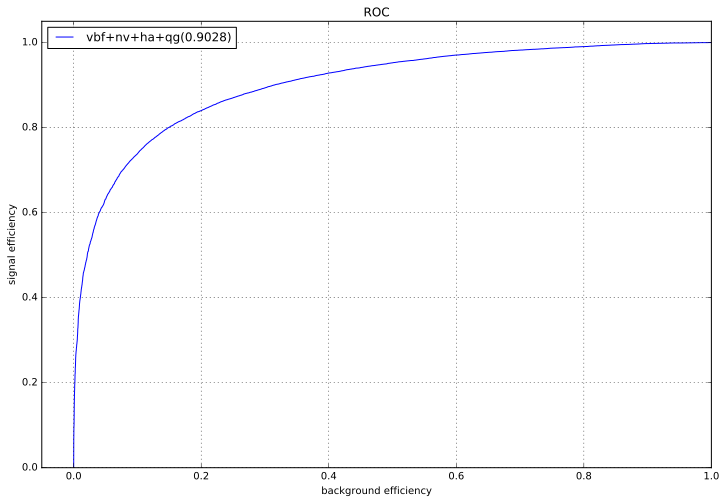

In [23]:
prune_3 = prune_2
prune_3_remove = ['tj2_pt']
prune_3 = [var for var in prune_2 if var not in prune_3_remove]
print 'priune_3: ', prune_3
prune_3_result = varset_training(gbm, signal, backgr, [prune_3])
plot_varset_training(prune_3_result, [ 'vbf+nv+ha+qg','prune 3'])

In [24]:
result_N_minus_1_prune_3 = n_minus_one_training(gbm, signal, backgr, prune_3)
get_ranking(result_N_minus_1_prune_3)

orig list:  ['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj1_pt', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg', 'all']
removing:  m_jj
['dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj1_pt', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg']
orig list:  ['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj1_pt', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg', 'all']
removing:  dEta_tj
['m_jj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj1_pt', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg']
orig list:  ['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj1_pt', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_centr

[('tj1_eta', -0.0055305551231579209),
 ('Z1_zepp', -0.0053185793413357274),
 ('Z2_zepp', -0.0049824235072724044),
 ('tj1_qg', -0.0045470921900531147),
 ('tj2_qg', -0.0033699617250793068),
 ('rel_pt_hard', -0.0030406310838619888),
 ('tj_delta_rel', -0.0030144963127550772),
 ('m_jj', -0.002269816939756697),
 ('ntj_central_scalar_sum_pt', -0.0019215254975539775),
 ('dEta_tj', -0.0017430701780626334),
 ('tj1_pt', -0.001354700033377787),
 ('m_4l', -0.0010681963777500192),
 ('ntj_n', -0.00081309699623266507),
 ('ntj_scalar_sum_pt', -0.00079657661336951513),
 ('ntj_central_n', -0.00057747186494516711),
 ('all', 0.0)]

priune_4:  ['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj1_pt', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg']
['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'dPhi_Z1_Z2', 'tj1_eta_x_tj2_eta', 'max_4l_eta', 'tj_min_eta', 'tj_max_eta', 'rel_pt_hard', 'tj_delta_rel', 'tj_sum_abs_eta', 'tj2_eta', 'tj1_eta', 'tj2_pt', 'tj1_pt', 'm_jj_over_dEta_tj', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_n', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg']
['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'rel_pt_hard', 'tj_delta_rel', 'tj1_eta', 'tj1_pt', 'ntj_n', 'ntj_scalar_sum_pt', 'ntj_central_scalar_sum_pt', 'tj1_qg', 'tj2_qg']


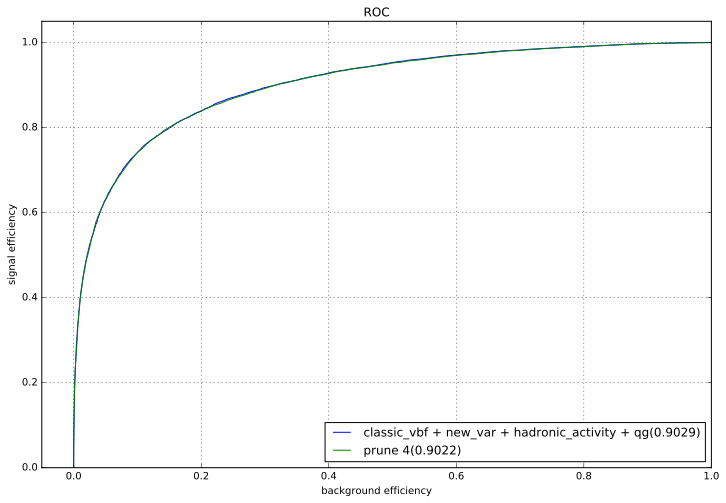

In [29]:
prune_4 = prune_3
prune_4_remove = ['ntj_central_n', 'all']
prune_4 = [var for var in prune_3 if var not in prune_4_remove]
print 'priune_4: ', prune_4
prune_4_result = varset_training(gbm, signal, backgr, [classic_vbf + new_var + hadronic_activity + qg, prune_4])
plot_varset_training(prune_4_result, [ 'classic_vbf + new_var + hadronic_activity + qg','prune 4'])

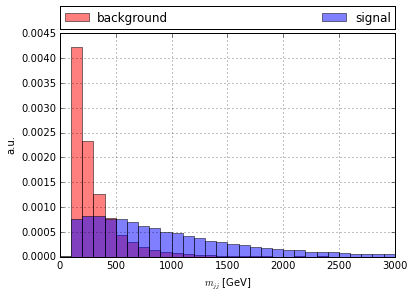

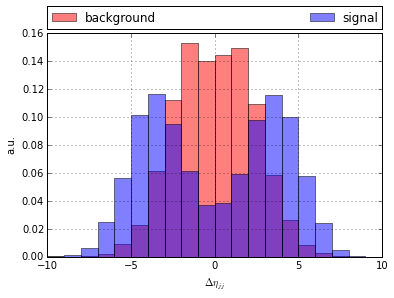

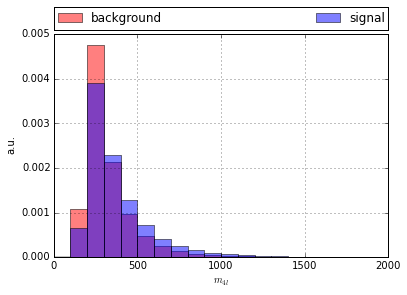

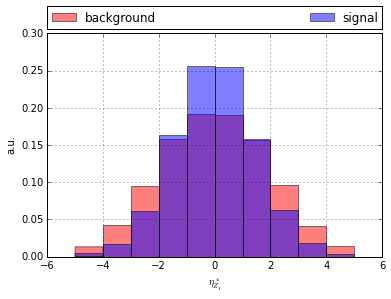

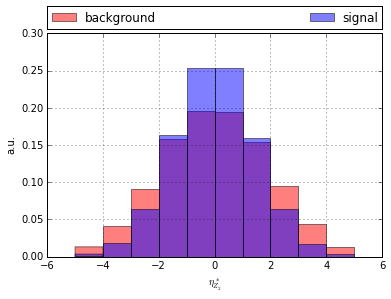

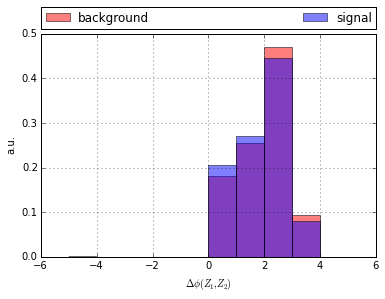

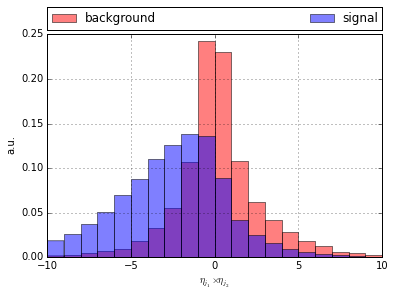

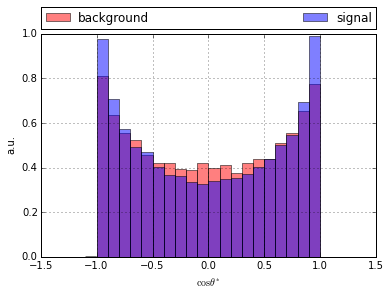

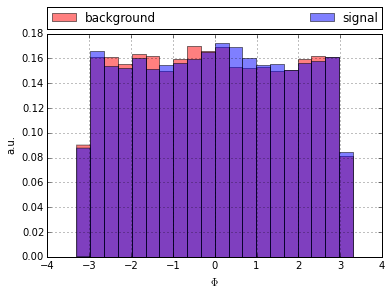

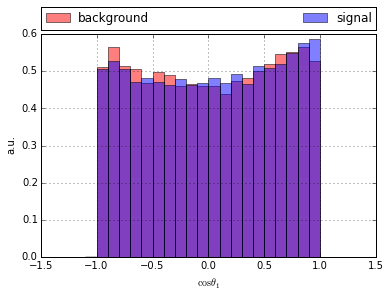

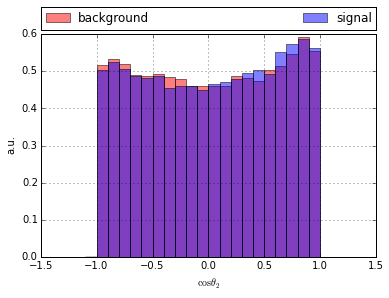

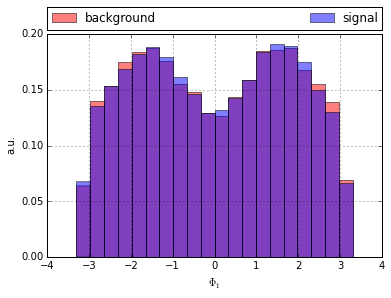

In [17]:
signal = rec2array(signal)
backgr = rec2array(backgr)
#'costhetastar', 'Phi', 'costheta1', 'costheta2', 'Phi1'
plots = [(r'$m_{jj}$ [GeV]', 30 , [0, 3000]),
         (r'$\Delta\eta_{jj}$', 20, [-10, 10]),
         (r'$m_{4l}$', 20, [0, 2000]),
         (r'$\eta^{*}_{Z_{1}}$', 10, [-5, 5]),
         (r'$\eta^{*}_{Z_{2}}$', 10, [-5, 5]),
         (r'$\Delta\phi(Z_{1}, Z_{2})$', 10, [-5,5]),
         (r'$\eta_{j_{1}}\times\eta_{j_{2}}$', 20, [-10, 10]),
         (r'$\cos{\theta^*}$', 22, [-1.1, 1.1]),
         (r'$\Phi$', 20, [-3.3, 3.3]),
         (r'$\cos \theta_1$', 22, [-1.1, 1.1]),
         (r'$\cos \theta_2$', 22, [-1.1, 1.1]),
         (r'$\Phi_1$', 20, [-3.3, 3.3]),
        ]
#fig = plt.figure()

 #'m_4l','Z1_zepp', 'Z2_zepp', 'dPhi_Z1_Z2', 'tj1_eta_x_tj2_eta'
#plt.subplots(2, 3)
for i in range(len(plots)) :
    #, i+1)
    p = plots[i]
    plt.hist(backgr[:,i], bins=p[1], range=p[2], normed=1, lw=1, alpha=0.5, color = 'red', label='background')
    plt.hist(signal[:,i], bins=p[1], range=p[2], normed=1, lw=1, alpha=0.5, label='signal')
#plt.locator_params(nbins=10)
#plt.locator_params(axis='y',nbins=20)
#plt.plot(gbdt_fpr, gbdt_tpr, lw=1, label='GBDT')
#plt.xlim([-0.0, 0.45])
#plt.ylim([-0.05, 1.05])
    plt.xlabel(p[0])
    plt.ylabel('a.u.')
    #plt.title('Receiver operating characteristic')
    #plt.legend(loc="best")
    plt.legend().set_visible(False)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    #plt.legend(numpoints=1)
    plt.grid()
    plt.show()

In [4]:
from sklearn.cross_validation import train_test_split

def single_varset_training(estimator, sig, back, variable_names = []) :
    
    var = variable_names
    
    print var


    red_back = rec2array(back[var])
    red_sig = rec2array(sig[var])

    X = np.concatenate((red_sig, red_back))
    y = np.concatenate((np.ones(sig.shape[0]) ,
                        np.zeros(back.shape[0])))


    X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                          test_size=0.33, random_state=42)
    X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev,
                                              test_size=0.33, random_state=492)

    est = copy.deepcopy(estimator)
    est.fit(X_train, y_train)

    est_decisions = est.predict_proba(X_test)[:, 1]
    est_fpr, est_tpr, thresholds = roc_curve(y_test, est_decisions)

    return (var, est, est_fpr, est_tpr)